# HOT Systems: Optimized Forest Model 

In [1]:
# standard
import math
import random
from tqdm.notebook import tqdm

# data science
import numpy as np
from scipy.ndimage.measurements import label as label_components


# visualization
import matplotlib.pyplot as plt
from IPython.core.display import HTML

In [2]:
def create_grid(L, spark=False, spark_distribution=None):
    
    if spark: # if a spark probability grid is desired
        spark_grid = create_grid(L)
        empty_idxs = np.ndindex(L, L)

        # filling cells of an empty grid with values from the specified spark distribution 
        characteristic_scale = L/10
        for idx in empty_idxs:
            spark_grid[idx[0], idx[1]] = spark_distribution_FUNC(idx, characteristic_scale)

        # normalizing probabilities (sum to one)
        spark_grid /= np.sum(spark_grid) 
        
        return spark_grid
    
        
    else: # otherwise creating a regular empty grid
        return np.zeros((L, L))

In [3]:
def plant_tree(forest_grid, idx):
    
    forest_grid_test = forest_grid.copy() # avoid overwriting actual forest in memory
    forest_grid_test[idx[0], idx[1]] = 1 # planting a new tree
    
    # connected components of trees and their sizes
    # ADD connectivity argument?
    components_grid, _ = label_components(forest_grid_test)
    components, counts = np.unique(components_grid, return_counts=True)
    component2size = dict(zip(components, counts))

    return forest_grid_test, component2size, components_grid

In [4]:
def burn_forest(forest_grid, spark_grid, connectivity, component2size, components_grid):
    
    # the expected total fire size with the newly planted tree
    expected_cost = 0 
    for idx in (np.argwhere(forest_grid==1)).tolist(): # for each tree
        tree_coords = idx[0], idx[1]
        
        # the probability of a lightning strike hitting this tree
        spark_probability = spark_grid[tree_coords]
        
        # getting the connected component and size that corresponds to this tree
        component_id = components_grid[tree_coords]

        # the size of the fire if this tree did catch (weighting the component size by probability)
        potential_fire_size = component2size[component_id] * spark_probability
        expected_cost += potential_fire_size
        

    return expected_cost

In [5]:
def simulate(L, D, connectivity, spark_distribution_FUNC):
    """
    Runs a single simulation with specified parameters.
    """
    forest_grid = create_grid(L) # creating the forest grid

    # creating the spark grid, where each value represents the probability of a spark
    spark_grid = create_grid(L, spark=True, spark_distribution=spark_distribution_FUNC)
    
    
    # run items and structures to populate with data
    tree_ct = 0 # to tally
    empty_idxs = np.argwhere(forest_grid==0).tolist()
    
    epoch2forest_grid = dict()
    epoch2cost = dict()
    epoch2yield = dict()
    
    
    # running the simulation
    completion = tqdm(total=len(empty_idxs), desc="Simulation (D={}, L={})".format(str(D), str(L)))
    while len(empty_idxs) > 0: # while there are still spaces left to plant a tree

        # pick 'D' cells to plant a tree
        if D <= len(empty_idxs):
            new_tree_idxs = random.sample(empty_idxs, D) 
        else: # D > number cells remaining
            new_tree_idxs = empty_idxs


        # figuring out what tree will result in the smallest expected fire burn
        new_tree2expected_cost = dict() 
        for idx in new_tree_idxs: 
            
            # plant the tree on a copy of the forest
            forest_grid_test, component2size, components_grid = plant_tree(forest_grid, idx) 
            
            # burn the forest down to assess the expected fire size and save the result
            new_tree2expected_cost[idx[0], idx[1]] = burn_forest(forest_grid_test, spark_grid, connectivity,
                                                                 component2size, components_grid)

        optimal_tree__cost = min(new_tree2expected_cost.items(), key=lambda x: x[1]) # tree with minimum cost

        
        # planting this tree in the original forest grid
        forest_grid, _, _ = plant_tree(forest_grid, optimal_tree__cost[0]) 
        empty_idxs.remove(list(optimal_tree__cost[0])) # removing this tree from the list of empty spaces


        # metric calculations
        tree_ct += 1
        forest_density = tree_ct/(L**2)
        
        # calculating timber yield (accounting for the expected fire size)
        timber_yield = forest_density - (optimal_tree__cost[1]/L**2)

        
        # saving values of interest 
        epoch2forest_grid[tree_ct] = forest_grid # note epochs are based at one here
        epoch2cost[tree_ct] = optimal_tree__cost[1]
        epoch2yield[tree_ct] = timber_yield
        
        completion.update(1)
    completion.close()
    
    
    # parsing run results for items of interest to return
    # the epoch with the greatest timber yield after expected fire size
    optimal_epoch = max(epoch2yield.items(), key=lambda x: x[1])[0]
    optimal_forest = epoch2forest_grid[optimal_epoch]
    
    
    return epoch2forest_grid, optimal_forest, epoch2yield

In [6]:
# parameters
L = 10 # size of grid world
D = L # design parameter representing how many trees to plant at each epoch
connectivity = 1 # 1=border/4 connectivity, 2=diagonal/8 connectivity

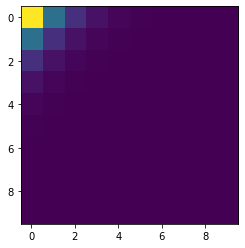

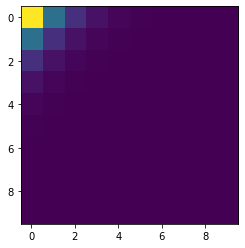

In [7]:
spark_distribution_FUNC = lambda idx, scale: math.exp(-idx[0]/scale) * math.exp(-idx[1]/scale)
plt.imshow(create_grid(L, spark=True, spark_distribution=spark_distribution_FUNC))

In [ ]:
idx2setting2data = {"id0":{"L":16, "D":1},
                    "id1":{"L":16, "D":2},
                    "id2":{"L":16, "D":16},
                    "id3":{"L":16, "D":16**2}}


# running each simulation
for idx, setting2data in idx2setting2data.items():
    setting2data["grids"],\
    setting2data["optimal_grid"],\
    setting2data["epoch2yield"] = simulate(setting2data["L"], setting2data["D"], 
                                           connectivity, spark_distribution_FUNC)

# plt.imshow(optimal_forest)

- sample no replacement

## Animating grids

In [ ]:
import plotly.express as px
from skimage import io

import plotly.offline as pyo
pyo.init_notebook_mode()

In [ ]:
fig = px.imshow(idx2setting2data["id1"]["optimal_grid"])
fig.show()

In [ ]:
img = np.array([idx2setting2data["id0"]["optimal_grid"], idx2setting2data["id1"]["optimal_grid"], 
                idx2setting2data["id1"]["optimal_grid"], idx2setting2data["id3"]["optimal_grid"]])
img.shape

In [ ]:
fig = px.imshow(img, facet_col=0, facet_col_wrap=4)
fig.show()

In [ ]:
frames = np.array(list(idx2setting2data["id1"]["grids"].values()))

In [ ]:
fig = px.imshow(frames[-500:], animation_frame=0, labels=dict(animation_frame="slice"))
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 10
fig.show()

In [ ]:
img = np.array([idx2setting2data["id0"]["grids"], idx2setting2data["id1"]["grids"], 
                idx2setting2data["id1"]["grids"], idx2setting2data["id3"]["grids"]])
img.shape

In [ ]:
# frames = np.array([np.array(list(im.values())) for im in img])
# frames.shape
structured_grids = list()
for idx, epoch in enumerate(range(len(idx2setting2data["id0"]["grids"]))):
    
    # the epochs start at one ('after one step')
    simulations_at_grid_idx = [idx2setting2data["id{}".format(str(sim_idx))]["grids"][idx+1]
                                  for sim_idx in list(range(4))]
    structured_grids.append(simulations_at_grid_idx)
    
    
structured_grids = np.array(structured_grids)
structured_grids.shape

In [ ]:
fig = px.imshow(structured_grids, animation_frame=0, facet_col=1, binary_string=True)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 0
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 0
fig.show()

## Line charts

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'html5'

In [ ]:
# x = np.arange(130, 190, 1)
# y = 97.928 * np.exp(- np.exp(-  0.1416 *( x - 146.1 )))
# z = 96.9684 * np.exp(- np.exp(-0.1530*( x - 144.4)))

x = np.array(list(idx2setting2data["id0"]["epoch2yield"].keys())) # same for all, starts at one

y1 = np.array(list(idx2setting2data["id0"]["epoch2yield"].values()))
y2 = np.array(list(idx2setting2data["id3"]["epoch2yield"].values()))

In [ ]:
# plt.style.use(['seaborn-notebook'])
plt.style.use('seaborn-poster')
fig, ax = plt.subplots()
ax.grid()

line1, = ax.plot(x, y1, color="r", label="fdsa")
line2, = ax.plot(x, y2, color="g", label="asdf")

def update(epoch, x, y1, y2, line1, line2):
    ax.set_xlabel('Epoch: {}'.format(str(epoch)))
    
    
    line1.set_data(x[:epoch], y1[:epoch])
    line2.set_data(x[:epoch], y2[:epoch])
    return [line1, line2]

ani = animation.FuncAnimation(fig, update, 
                              len(x), 
                              fargs=[x, y1, y2, line1, line2],
                              interval=30, # delay (ms)
                              blit=True) 

fig.suptitle("asdf")
ax.set_xlabel('Epoch')
ax.set_ylabel('yaxis')
plt.legend()


writervideo = animation.FFMpegWriter(fps=60)
ani.save('./yield_curves.mp4', writer=writervideo)
plt.close()

In [ ]:
HTML(ani.to_html5_video())